In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/DogsDataSet.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

In [10]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import vgg16
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [3]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         #transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         #transforms.RandomResizedCrop((224,224)),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/train', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/val', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/test', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
    
    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

def load_network(net_model, net_name, dropout_ratio, class_names, unfrozen_layers):
    for name, child in net_model.named_children():
        if name in unfrozen_layers:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True
        else:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False

    if net_name.startswith('resnet'):
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))

    elif net_name.startswith('vgg'):
        num_ftrs = net_model.classifier[6].in_features
        net_model.classifier[6] = nn.Linear(num_ftrs, 256)
    elif net_name.startswith('inception'):
        num_ftrs = net_model.AuxLogits.fc.in_features
        net_model.AuxLogits.fc = nn.Linear(num_ftrs, len(class_names))
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Linear(num_ftrs,len(class_names))

    display(net_model)
    
    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')
    
    return net_model

In [4]:
def plot_images_per_class(images_path, mode, title):
    data_folder = images_path+'/'+mode+'/'
    item_dict = {root.split('/')[-1]: len(files) for root, _, files in os.walk(data_folder)}
   
    plt.figure(figsize=(20,8))
    plt.bar(list(item_dict.keys())[1:], list(item_dict.values())[1:], color='g')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
    sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
    train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)
    
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    plt.figure(figsize=(size,size))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.title(class_names[labels.numpy()[i]])
        img = images[i].permute(1,2,0)
        img = torch.tensor(std)*img + torch.tensor(mean)
        plt.axis('off')
        plt.imshow(img, interpolation='none')
        plt.tight_layout()

In [5]:
def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    #if not os.path.exists(results_path+'/'+model_name):
    #    os.makedirs(results_path+'/'+model_name)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    #optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)
    
    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    y_testing = []
    preds = []
    
    min_val_loss = np.Inf
    epochs_no_improv = 0
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')
    
    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()
            
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()
                # print(model(inputs))
                output = model(inputs)
                loss = criterion(output, targets)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())
                
                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]
                
                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
            
            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            
            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')
            
            if mode == 'val':
                scheduler.step(epoch_loss)
        
        if mode == 'val':
            if epoch_loss < min_val_loss:
                # torch.save(model.state_dict(), '/kaggle/working/'+str(model_name)+'.pth')
                torch.save(model.state_dict(), '/content/'+str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                # model.load_state_dict(torch.load('/kaggle/working/'+str(model_name)+'.pth'))
                model.load_state_dict(torch.load('/content/'+str(model_name)+'.pth'))
                
    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    # model.load_state_dict(torch.load('/kaggle/working/'+str(model_name)+'.pth'))
    model.load_state_dict(torch.load('/content/'+str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    preds = []
    trues = []
    
    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()
            
        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [6]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    #if not os.path.exists(results_path+'/'+model_name):
    #    os.makedirs(results_path+'/'+model_name)

    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)
    
    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)
    
    #plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_conf_mat.png')
    
def plot_logs_classification(results_path, model_name, logs):
    """
    """
    #if not os.path.exists(results_path+'/'+model_name):
    #    os.makedirs(results_path+'/'+model_name)
        
    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['val'], logs[1]['val']
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()

In [7]:
images_path = '/content/images/Images/'
results_path = images_path+'_results'
presplit = False
train_split = 0.5
val_split = 0.25
test_split = 0.25
batch_size = 128
threads = 0
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

class_names = dataset.classes
class_names = [classes[10:] for classes in class_names]
print(class_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

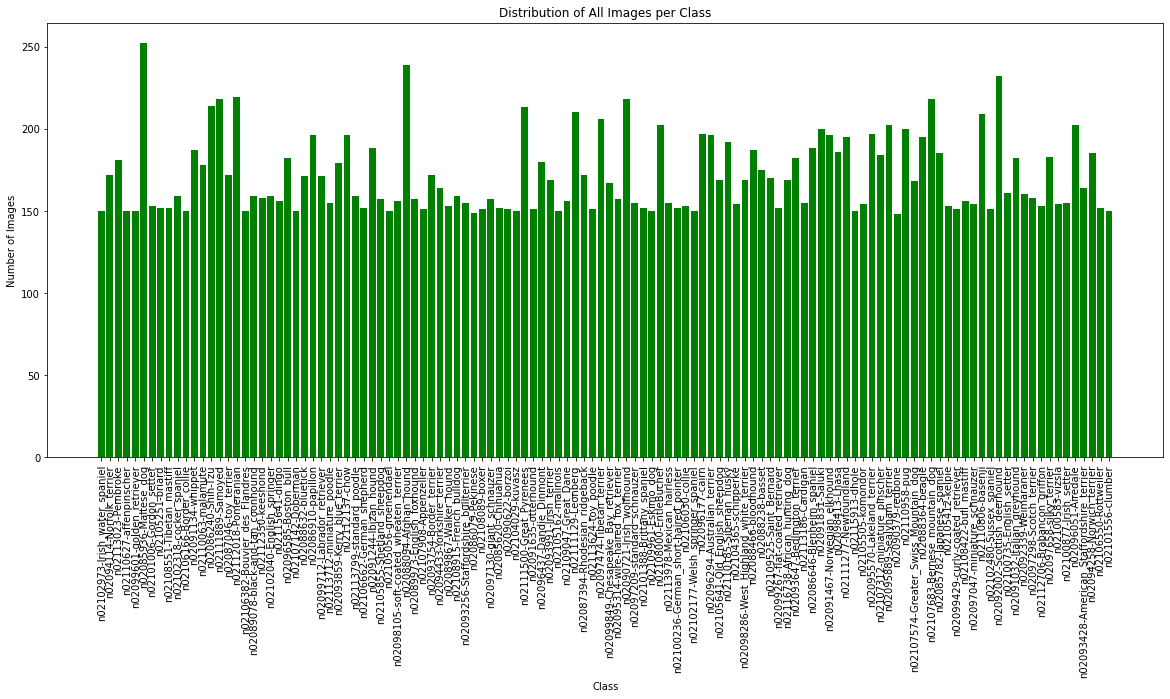

In [8]:
if presplit:
    plot_images_per_class(images_path, mode='train', title='Distribution of Training Data per Class')
    plot_images_per_class(images_path, mode='val', title='Distribution of Validation Data per Class')
    try:
        plot_images_per_class(images_path, mode='test', title='Distribution of Testing Data per Class')
    except:
        pass
else:
    plot_images_per_class(images_path, mode='', title='Distribution of All Images per Class')

In [11]:
net_model = vgg16(pretrained=True)
net_name = 'vgg16'
net_model.aux_logits=False
unfrozen_layers = [] 

dropout_ratio = 0.9

net_model = load_network(net_model, net_name, dropout_ratio, class_names, unfrozen_layers)

print(f'Images in training set {len(training_set)}, validation set {len(validation_set)}, testing set {len(testing_set)}')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

features is frozen
avgpool is frozen
classifier is frozen


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

135,309,376 total parameters
1,048,832 training parameters
Images in training set 10290, validation set 5145, testing set 5145


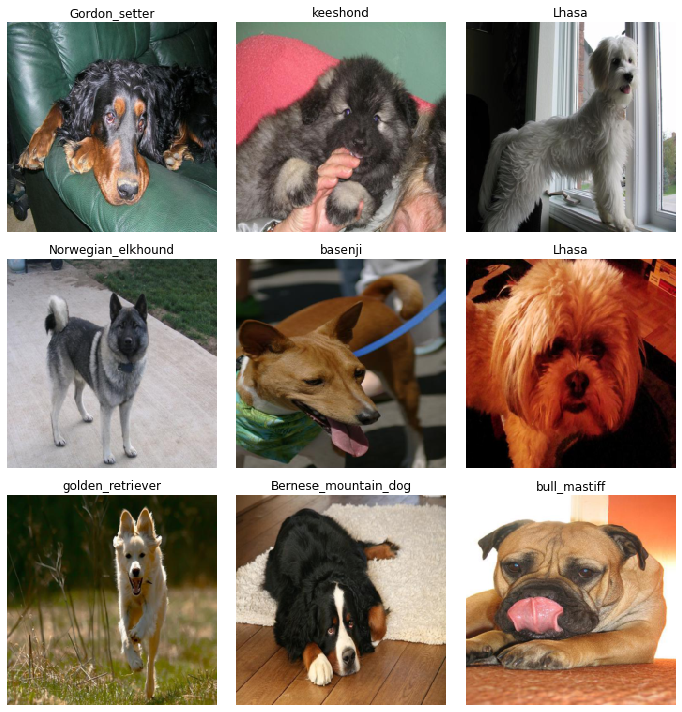

In [12]:
plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=10)

In [13]:
learning_rate = 0.0001
epochs = 100
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(results_path, net_name, net_model, training_set_loader, validation_set_loader, 
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs
[train] Epoch 1/100 Iteration 1/81 Loss: 5.71 Accuracy: 0.01
[train] Epoch 1/100 Iteration 17/81 Loss: 5.19 Accuracy: 0.04
[train] Epoch 1/100 Iteration 33/81 Loss: 4.64 Accuracy: 0.12
[train] Epoch 1/100 Iteration 49/81 Loss: 4.19 Accuracy: 0.19
[train] Epoch 1/100 Iteration 65/81 Loss: 3.85 Accuracy: 0.26
[train] Epoch 1/100 Iteration 81/81 Loss: 3.56 Accuracy: 0.31
[train] Epoch 1/100 Iteration 81/81 Loss: 3.56 Accuracy: 0.31
[val] Epoch 1/100 Iteration 1/41 Loss: 2.24 Accuracy: 0.67
[val] Epoch 1/100 Iteration 9/41 Loss: 2.21 Accuracy: 0.71
[val] Epoch 1/100 Iteration 17/41 Loss: 2.21 Accuracy: 0.69
[val] Epoch 1/100 Iteration 25/41 Loss: 2.20 Accuracy: 0.70
[val] Epoch 1/100 Iteration 33/41 Loss: 2.21 Accuracy: 0.70
[val] Epoch 1/100 Iteration 41/41 Loss: 2.21 Accuracy: 0.70
[val] Epoch 1/100 Iteration 41/41 Loss: 2.21 Accuracy: 0.70
[train] Epoch 2/100 Iteration 1/81 Loss: 2.28 Accuracy: 0.56
[train] Epoch 2/100 Iteration 17/81 Loss: 2.00 Accuracy: 0.63
[train] Epoch

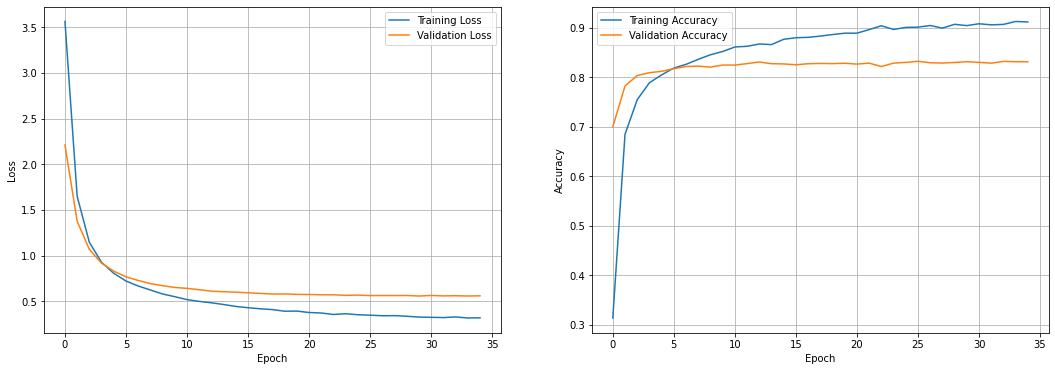

In [14]:
plot_logs_classification(results_path, net_name, loss_acc)

In [15]:
preds_test, y_true = test_model(net_name, net_model, testing_set_loader)

Iteration 1/41
Iteration 9/41
Iteration 17/41
Iteration 25/41
Iteration 33/41
Iteration 41/41


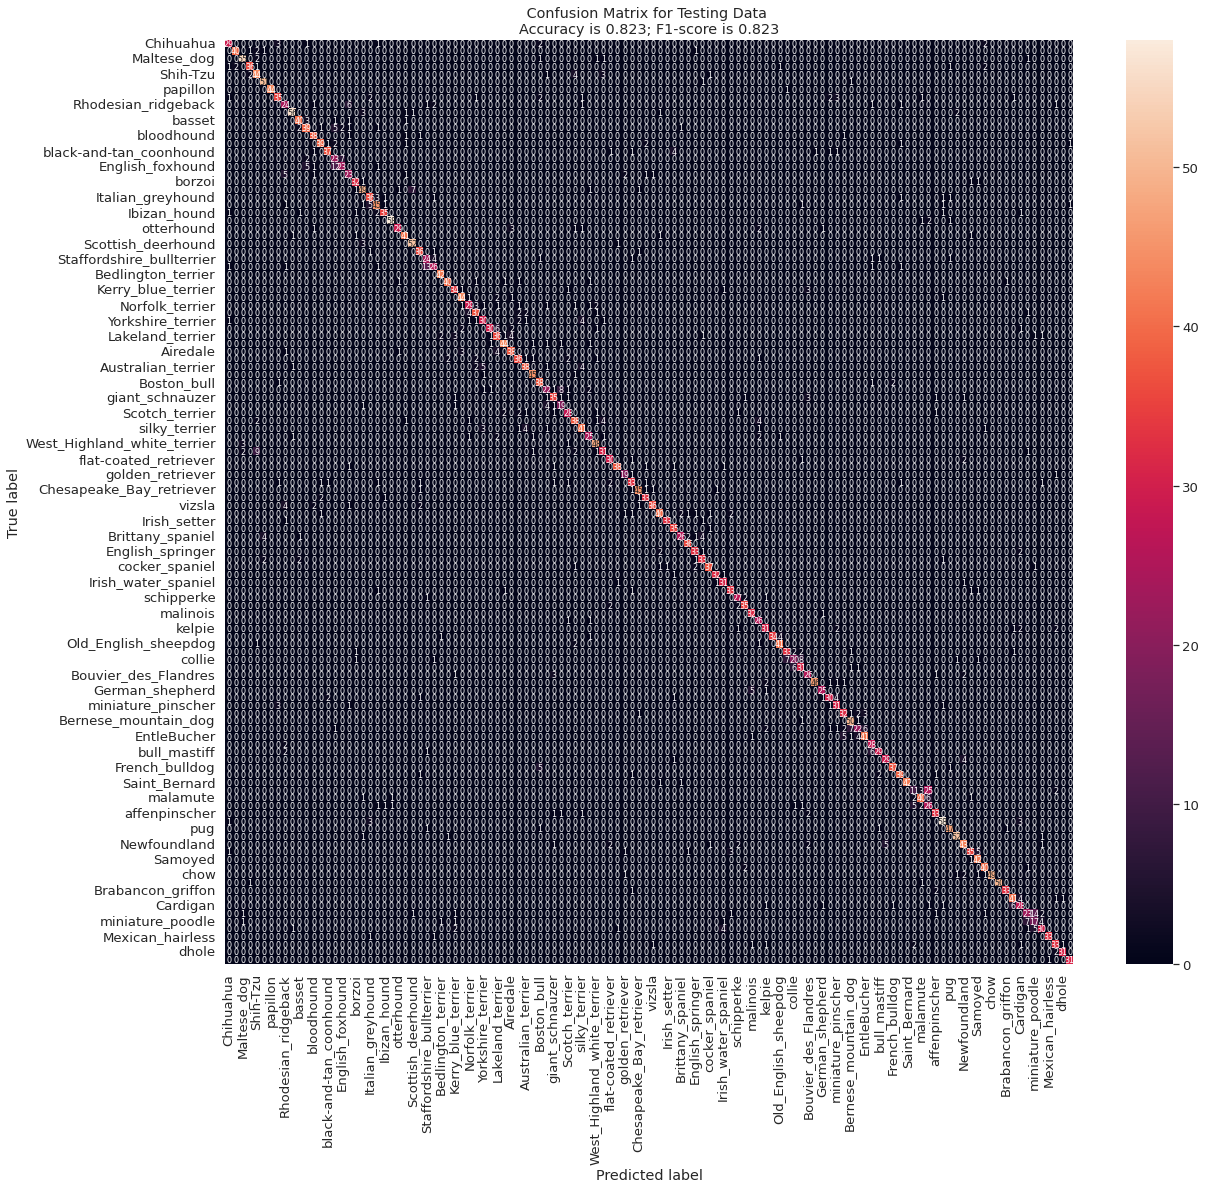

In [16]:
display_confusion_matrix(results_path, net_name, y_true, preds_test, class_names, annot=True, figsize=(19,17), fontsize=8)

In [17]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                                precision    recall  f1-score   support

                     Chihuahua       0.81      0.76      0.78        38
              Japanese_spaniel       0.95      0.89      0.92        45
                   Maltese_dog       0.89      0.90      0.89        61
                      Pekinese       0.90      0.82      0.86        44
                      Shih-Tzu       0.72      0.80      0.76        55
              Blenheim_spaniel       0.88      0.96      0.92        53
                      papillon       1.00      0.98      0.99        45
                   toy_terrier       0.81      0.71      0.76        49
           Rhodesian_ridgeback       0.59      0.63      0.61        38
                  Afghan_hound       0.93      0.88      0.90        64
                        basset       0.87      0.87      0.87        46
                        beagle       0.78      0.75      0.76        52
                    bloodhound       0.84      0.90      0.87  